# ASR Model

In this notebook we create a Automatic Speech Recognition Model based on [Mozilla's DeepSpeech Model](https://github.com/mozilla/DeepSpeech) and [Baidu's Deep Speech Paper](https://arxiv.org/abs/1412.5567). A lot of the code in this notebook is based on the source code of the [deepspeech-keras library](https://github.com/val260/DeepSpeech-Keras) and in some cases will directly parallel that code (we would undoubtedly fail a plagarism checker and that's why we would like to be upfront with our sources). Developing this notebook, however, required us to 
* understand how each component of the DeepSpeech model works,
* migrate a library distributed over many files into a single notebook,
* and convert code from Keras to Tensorflow 2.3.0 Keras

## Link To Drive



There are a few files that we will need to run this notebook. These should be located in Model directory within our repository. If you have been following our setup instructions in the Github.ipynb file, you won't have to change any of the file paths below.

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd "/content/drive/My Drive/Research/FIRE/2020-Speech-Recognition/Model"
!ls

/content/drive/My Drive/Research/FIRE/2020-Speech-Recognition/Model
alphabet.txt	 callbacks.py	     __pycache__
ASR_Model.ipynb  configuration.yaml  StarWars60.wav


## Install Required Libraries

As long as you are using Google Colab, the only required library is the python_speech_features library. All other libraries come included with Google Colab. 

In [1]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=cd2486fb28c3b1fdf790f306e5f769f9db360bd1babfe8ae7ba0800ee0520f9c
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


## Encode Audio

To perform speech recognition our audio data, we want to first preprocess each audio file to provide us with input features. The code blocks below extract the features from a given audio file using librosa and python_speech_features. We also run this code on a sample audio file with 60 seconds of the Stars Wars theme to test our ability to create features from audio data.

In [2]:
import numpy as np
import python_speech_features
import librosa

conf = {"winfunc": np.hamming, "winlen": 0.025, "winstep": .01, "nfilt": 80}

def get_features(files):
    mfccs = [make_features(file) for file in files]
    X = align(mfccs)
    return X

def make_features(file_path):
    """ Use `python_speech_"features` lib to extract MFCC features from the audio file. """
    audio, fs = librosa.load(file_path, sr=16000)
    audio = (audio * 32768).astype("int16")
    feat, energy = python_speech_features.fbank(audio, samplerate=fs, **conf)
    features = np.log(feat)
    return features

def align(arrays, default=0):
    """ Pad arrays along time dimensions. Return the single array (batch_size, time, features). """
    max_array = max(arrays, key=len)
    X = np.full(shape=[len(arrays), *max_array.shape], fill_value=default, dtype=np.float64)
    for index, array in enumerate(arrays):
        time_dim, features_dim = array.shape
        X[index, :time_dim] = array
    return X

In [3]:
X = get_features(["StarWars60.wav"])
X.shape

(1, 5999, 80)

## Alphabet

The next step is to get our alphabet. The alphabet defines what letters are included in our classified text. Our alphabet file includes 36 characters right now, but we may want to reduce this to only the 26 letters and an empty space from the English alphabet. 

In [12]:
from alphabet import Alphabet
alphabet = Alphabet("alphabet.txt")

## Create Model

In the code cells below, we create the model that we will be using for Speech To Text Recognition. 

In [5]:
from tensorflow.config import list_physical_devices
model_dir = "models/"
gpus = list_physical_devices("GPU")

### Layers

To build the model, we use the Functional API provided by Tensorflow Keras. The code cells below build the model based on the structure of DeepSpeech. There are also some optimizations included for whether there are gpus being utilized for this task.

In [4]:
from typing import List
from keras import Model
import tensorflow
#from keras.initializers import np
from tensorflow import expand_dims, squeeze
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Input, Lambda, LSTM, Bidirectional, Dense, ReLU, \
    TimeDistributed, BatchNormalization, Dropout, ZeroPadding2D, Conv2D, Reshape

In [6]:
input_dim = 80
is_gpu = len(gpus) > 0
output_dim = 36
context = 7
units = 1024
dropouts = [0.1, .1, 0]
random_state = 1

#np.random.seed(1)
tensorflow.random.set_seed(random_state)
input_tensor = Input([None, input_dim], name='X')                           # Define input tensor [time, features]
x = Lambda(expand_dims, arguments=dict(axis=-1))(input_tensor)              # Add 4th dim (channel)
x = ZeroPadding2D(padding=(context, 0))(x)                                  # Fill zeros around time dimension
receptive_field = (2*context + 1, input_dim)                                # Take into account fore/back-ward context
x = Conv2D(filters=units, kernel_size=receptive_field)(x)                   # Convolve signal in time dim
x = Lambda(squeeze, arguments=dict(axis=2))(x)                              # Squeeze into 3rd dim array
x = ReLU(max_value=20)(x)                                                   # Add non-linearity
x = Dropout(rate=dropouts[0])(x)                                            # Use dropout as regularization

x = TimeDistributed(Dense(units))(x)                                        # 2nd and 3rd FC layers do a feature
x = ReLU(max_value=20)(x)                                                   # extraction base on the context
x = Dropout(rate=dropouts[1])(x)

x = TimeDistributed(Dense(units))(x)
x = ReLU(max_value=20)(x)
x = Dropout(rate=dropouts[2])(x)

x = Bidirectional(CuDNNLSTM(units, return_sequences=True) if is_gpu else     # LSTM handle long dependencies
                    LSTM(units, return_sequences=True, ),
                    merge_mode='sum')(x)

output_tensor = TimeDistributed(Dense(output_dim, activation='softmax'))(x)  # Return at each time step prob along characters

model = Model(inputs=input_tensor, outputs=output_tensor)

### Loss Function

For our loss function, we use a CTC Loss. The CTC loss helps with the problem of alignment where we don't know which portion of the audio corresponds to which letter (just that certain audio corresponds to certain phrases or words). This loss is described in detail [here](https://distill.pub/2017/ctc/). 

In [7]:
def ctc_loss(y, y_hat):
    def get_length(tensor):
        lengths = tf.reduce_sum(tf.ones_like(tensor), 1)
        return tf.reshape(tf.cast(lengths, tf.int32), [-1, 1])

    sequence_length = get_length(tf.reduce_max(y_hat, 2))
    label_length = get_length(y)
    return tf.keras.backend.ctc_batch_cost(y, y_hat, sequence_length, label_length)

loss = ctc_loss

### Optimizer

For our optimizer, we use the standard Adam Optimzier. The configurations below are the default configurations for an Adam Optimizer but can be tuned in the future.

In [8]:
from keras.optimizers import Optimizer, SGD, Adam

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

### Compile The Model

We have enough components at this point to compile our model with the given optimizer and loss. The DeepSpeech Keras model also included target_tensors in their compiled model. I don't have a good enough understanding of target_tensors to state what they do, but they have been discontinued starting Tensorflow 2.2.0. Currently the lines for adding target_tensors have been commented out, but we may need to consider how to fix this issue of deprecation.

In [15]:
from keras.utils import multi_gpu_model
#print(tf.__version__)
gpus_num = len(gpus)
compiled_model = multi_gpu_model(model, gpus_num) if gpus_num > 1 else model
#y = Input(name='y', shape=[None], dtype='int32')
compiled_model.compile(optimizer, loss)#, target_tensors=[y], run_eagerly=False)
compiled_model.template_model = model

### Test The Model

We can also test our model on the sample audio file that we had extracted features from earlier. The decoder has not been set up yet so we take a rudimentary approach of removing all consecutive duplicates. We don't expect this model to classify anything at this point since it has been created with random weights, but this allows us to add a sanity check to see that our model is processing our input features and creating an output vector of probabilities for each character. 

In [19]:
y_hat = compiled_model.predict_on_batch(X)

In [20]:
arr = [alphabet.string_from_label(l) for l in np.apply_along_axis(np.argmax, 1, y_hat[0])]
arr = [arr[0]] + [arr[i] for i in range(1,len(arr)) if arr[i] != arr[i-1]]
arr

['o', 'ś', 'w', 'l', 'w', '', 'l', '', 'o', '', 'y']

## Callbacks

In [9]:
from keras.callbacks import Callback, TerminateOnNaN, LearningRateScheduler, ReduceLROnPlateau, History
from callbacks import ResultKeeper, CustomModelCheckpoint, CustomTensorBoard, CustomEarlyStopping
callbacks = []
callbacks.append(TerminateOnNaN())
callbacks.append(ResultKeeper("results.bin"))
callbacks.append(CustomModelCheckpoint('checkpoints'))
callbacks.append(CustomTensorBoard('tensorboard'))
callbacks.append(CustomEarlyStopping(mini_targets={5: 200, 10:100}, monitor="val_loss", patience=3))
lr_decay = lambda epoch, lr: lr / np.power(.1, epoch)
callbacks.append(LearningRateScheduler(lr_decay, verbose= 1))

## Decoder

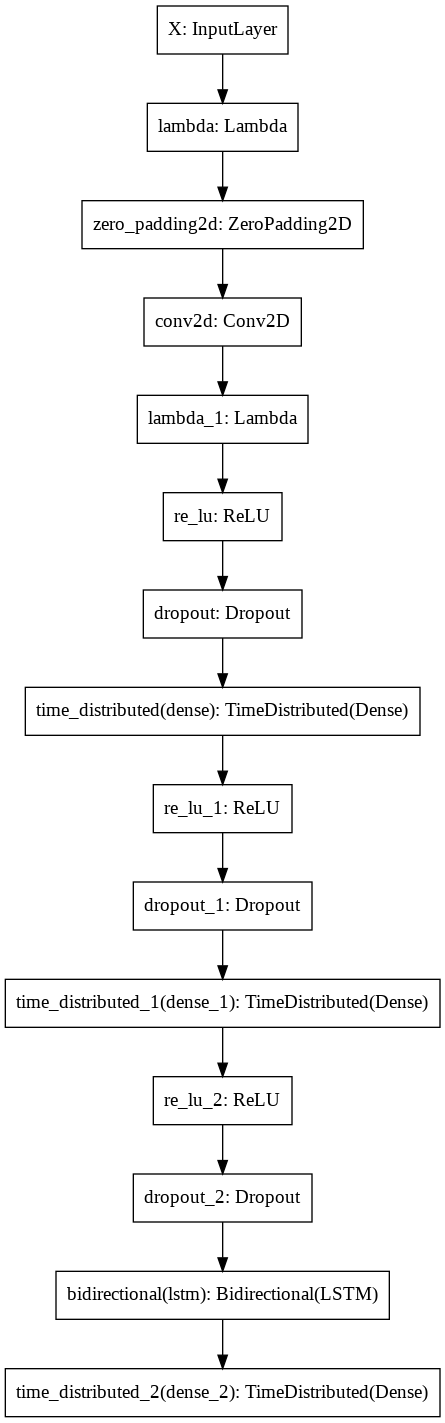

In [13]:
from keras.utils import plot_model 
plot_model(model, to_file='model.png')

In [ ]:
model.layers[-1].output

<tf.Tensor 'time_distributed_11/Reshape_1:0' shape=(None, None, 36) dtype=float32>

In [41]:
from functools import partial
from tensorflow.keras import backend as K

def get_decoder(output_tensor):
    def get_length(tensor):
        lengths = tf.reduce_sum(tf.ones_like(tensor), 1)
        return tf.cast(lengths, tf.int32)

    sequence_length = get_length(tf.reduce_max(output_tensor, 2))
    top_k_decoded, _ = K.ctc_decode(output_tensor, sequence_length, greedy=False, beam_width=64)
    print(top_k_decoded[0])
    decoder = K.function([output_tensor], [top_k_decoded[0]])
    return decoder

print(model.output)
decoder = get_decoder(model.output)
decoder = partial(ctc_decoder.batch_tensorflow_decode, alphabet=alphabet, decoder=decoder)

Tensor("time_distributed_2/Reshape_1:0", shape=(None, None, 36), dtype=float32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Tensor("SparseToDense:0", shape=(None, None), dtype=int64)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: time_distributed_2/Reshape_1:0


ValueError: ignored